In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset,DataLoader
import torchvision.transforms as transforms
from  torchvision.datasets import ImageFolder
from torch.autograd import Variable
import cv2
import numpy as np
import os, random,sys

# Build an Autoencoder for a human face dataset

We will use a dataset containig images of people and train an autoencoder on it.

## Step 1

Download and unzip the ``lfw.zip`` file . Adjust the ``path`` variable so that it contains the address of the unzipped folder. We will create a dataloader from this folder.


In [2]:
path = '/content/lfw'

In [3]:
!unzip /content/drive/MyDrive/lfw.zip

Streaming output truncated to the last 5000 lines.
  inflating: lfw/Recep_Tayyip_Erdogan/Recep_Tayyip_Erdogan_0021.jpg  
  inflating: __MACOSX/lfw/Recep_Tayyip_Erdogan/._Recep_Tayyip_Erdogan_0021.jpg  
  inflating: lfw/Recep_Tayyip_Erdogan/Recep_Tayyip_Erdogan_0020.jpg  
  inflating: __MACOSX/lfw/Recep_Tayyip_Erdogan/._Recep_Tayyip_Erdogan_0020.jpg  
  inflating: lfw/Recep_Tayyip_Erdogan/Recep_Tayyip_Erdogan_0008.jpg  
  inflating: __MACOSX/lfw/Recep_Tayyip_Erdogan/._Recep_Tayyip_Erdogan_0008.jpg  
  inflating: lfw/Recep_Tayyip_Erdogan/Recep_Tayyip_Erdogan_0022.jpg  
  inflating: __MACOSX/lfw/Recep_Tayyip_Erdogan/._Recep_Tayyip_Erdogan_0022.jpg  
  inflating: lfw/Recep_Tayyip_Erdogan/Recep_Tayyip_Erdogan_0023.jpg  
  inflating: __MACOSX/lfw/Recep_Tayyip_Erdogan/._Recep_Tayyip_Erdogan_0023.jpg  
  inflating: lfw/Recep_Tayyip_Erdogan/Recep_Tayyip_Erdogan_0012.jpg  
  inflating: __MACOSX/lfw/Recep_Tayyip_Erdogan/._Recep_Tayyip_Erdogan_0012.jpg  
  inflating: lfw/Recep_Tayyip_Erdogan/Recep

In [4]:
transform    = transforms.Compose([transforms.ToTensor()])
dataloader = DataLoader(ImageFolder(path, transform,),batch_size=32, shuffle=True)

This project is compute intensive. If you have a cuda or mps device on your laptop make sure you use that in the training.

In [5]:
# Check for CUDA GPU availability
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using CUDA device:", torch.cuda.get_device_name(0))
else:
    print("CUDA device not found.")

Using CUDA device: Tesla T4


torch.Size([250, 250, 3])


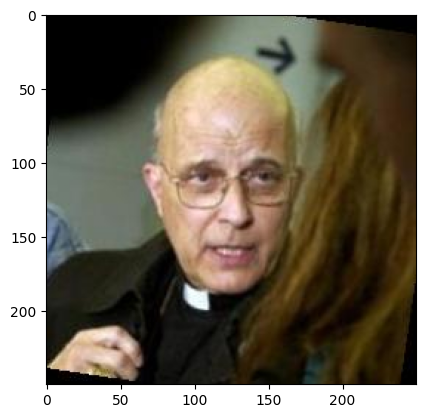

In [6]:
for x,y in dataloader:
    x = x[0].permute(1, 2, 0)
    print(x.shape)
    plt.imshow(x)
    break

## Step 2
Each datapoint is an image. Get a sample of the data and print its dimensions and explain what each dimension means.

Dimensions of the sample image: torch.Size([3, 250, 250])

Explanation of each dimension:
1st Dimension (Channels): 3 - Number of color channels (3 for RGB)
2nd Dimension (Height): 250 - Height of the image in pixels
3rd Dimension (Width): 250 - Width of the image in pixels


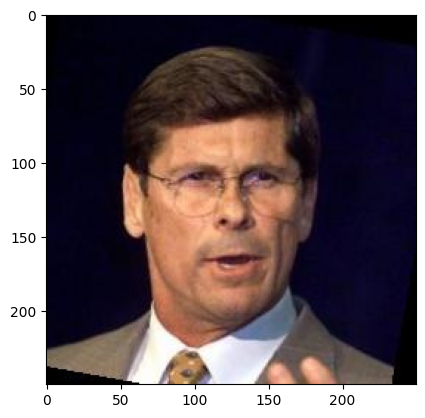

In [49]:
# Fetch a single batch of data
data_iter = iter(dataloader)
images, labels = next(data_iter)

# Select the first image from the batch
sample_image = images[0]

# Print the dimensions of the sample image
print("Dimensions of the sample image:", sample_image.shape)
# Dimensions
print("\nExplanation of each dimension:")
print("1st Dimension (Channels):", sample_image.shape[0], "- Number of color channels (3 for RGB)")
print("2nd Dimension (Height):", sample_image.shape[1], "- Height of the image in pixels")
print("3rd Dimension (Width):", sample_image.shape[2], "- Width of the image in pixels")


# To display the image, we need to permute the dimensions
sample_image = sample_image.permute(1, 2, 0)
plt.imshow(sample_image)
plt.show()

# Step 3

Create a new pytorch model calss for your autoencoder. You can use Conv2d, MaxPool2d, BatchNorm2d, ConvTranspose2d and Linear Layers as as well as activation functions. Optionally, you can use UpSample, AveragePool2d and Interpolate2d as well.

**Create seperate functions for the encoder and decoder.**

Below is the AE (AutoEncoder) class outlined with separate methods for the encoder and decoder. The architecture has convolutional layers (good for image data), batch normalization (to stabilize learning), and non-linear activation functions.

The architecture will be relatively simple but can be a good starting point for the assignment (given the computation resources).

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class AE(nn.Module):
    def __init__(self):
        super(AE, self).__init__()

        # Encoder Layers
        self.enc_conv1 = nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1)
        self.enc_bn1 = nn.BatchNorm2d(64)
        self.enc_avgpool1 = nn.AvgPool2d(kernel_size=2, stride=2)
        self.enc_conv2 = nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1)
        self.enc_bn2 = nn.BatchNorm2d(128)

        # Decoder Layers
        self.dec_upsample1 = nn.Upsample(size=(62, 62), mode='nearest')
        self.dec_conv1 = nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1)
        self.dec_bn1 = nn.BatchNorm2d(64)
        self.dec_upsample2 = nn.Upsample(size=(125, 125), mode='nearest')
        self.dec_conv2 = nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1)
        self.dec_bn2 = nn.BatchNorm2d(32)
        self.dec_upsample3 = nn.Upsample(size=(250, 250), mode='nearest')
        self.dec_conv3 = nn.ConvTranspose2d(32, 3, kernel_size=3, stride=1, padding=1)
        self.dec_bn3 = nn.BatchNorm2d(3)


    def encoder(self, x):
        x = F.relu(self.enc_bn1(self.enc_conv1(x)))
        x = self.enc_avgpool1(x)
        x = F.relu(self.enc_bn2(self.enc_conv2(x)))
        return x

    def decoder(self, x):
        x = self.dec_upsample1(x)
        x = F.relu(self.dec_bn1(self.dec_conv1(x)))
        x = self.dec_upsample2(x)
        x = F.relu(self.dec_bn2(self.dec_conv2(x)))
        x = self.dec_upsample3(x)
        x = self.dec_bn3(self.dec_conv3(x))
        x = torch.sigmoid(x)  # Normalize the output
        return x

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

## Step 4
Create an instance of the class, pass an image to the model, print the shape of the output of the **encoder** and the **decoder**. Check the dimensions and make sure your forward path is working properly.

In [10]:
# Create an instance of the AE model
model_initial = AE()

# Check if CUDA is available and move the model to GPU if possible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_initial.to(device)

# Fetch a sample image from the DataLoader
data_iter = iter(dataloader)
images, _ = next(data_iter)
sample_image = images[0].unsqueeze(0)  # Add a batch dimension
sample_image = sample_image.to(device)

# Pass the image through the model
with torch.no_grad():
    encoded = model_initial.encoder(sample_image)
    decoded = model_initial.decoder(encoded)

# Print the shapes
print("Shape of encoder output:", encoded.shape)
print("Shape of decoder output:", decoded.shape)


Shape of encoder output: torch.Size([1, 128, 31, 31])
Shape of decoder output: torch.Size([1, 3, 250, 250])


##  Step 5
Print total number of parameters in the model, explain what loss function you should use, create an optimizer for training

The choice of loss function is critical as it dictates how the model's performance is measured and optimized. Given that the primary goal of an autoencoder is to learn a compact representation of the input data and reconstruct it as accurately as possible, a common choice is the Mean Squared Error (MSE) loss. MSE computes the average squared difference between the reconstructed image and the original image, effectively penalizing the model for any disparities between the two.

MSE is particularly suited to regression tasks where we want to penalize the model more for larger errors, which makes it a natural fit for reconstruction tasks where pixel-wise accuracy is important.

In [11]:
# Print total number of parameters
total_params = sum(p.numel() for p in model_initial.parameters())
print("Total number of parameters in the model:", total_params)

# Loss function
loss_function = nn.MSELoss()

# Optimizer
optimizer = torch.optim.Adam(model_initial.parameters(), lr=0.001)

Total number of parameters in the model: 299721


In [16]:
model_initial

AE(
  (enc_conv1): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (enc_bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (enc_avgpool1): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (enc_conv2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (enc_bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dec_upsample1): Upsample(size=(62, 62), mode='nearest')
  (dec_conv1): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (dec_bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dec_upsample2): Upsample(size=(125, 125), mode='nearest')
  (dec_conv2): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (dec_bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dec_upsample3): Upsample(size=(250, 250), mode='nearest')
  (dec_conv3): ConvTranspose2d(32, 

##  Step 6
Write a training loop and start trainng the model for several epochs. Report the loss value at the end of each epoch and monitor it. If your loss is not decreasing what do you have to do to troubleshoot it ?

In [42]:
num_epochs = 30  # Set the number of epochs

for epoch in range(num_epochs):
    running_loss = 0.0

    for data in dataloader:
        # Split data into inputs and targets
        inputs, _ = data
        inputs = inputs.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model_initial(inputs)
        loss = loss_function(outputs, inputs)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Accumulate loss
        running_loss += loss.item()

    # Compute average loss for this epoch
    epoch_loss = running_loss / len(dataloader)
    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss}')


Epoch 1/30, Loss: 0.0008824005131643481
Epoch 2/30, Loss: 0.000882596887956297
Epoch 3/30, Loss: 0.0008823134489852377
Epoch 4/30, Loss: 0.0008823802734889396
Epoch 5/30, Loss: 0.0008824750022391299
Epoch 6/30, Loss: 0.0008824337373660869
Epoch 7/30, Loss: 0.0008824467043176402
Epoch 8/30, Loss: 0.0008823486017726884
Epoch 9/30, Loss: 0.0008823862871557817
Epoch 10/30, Loss: 0.0008823538189506437
Epoch 11/30, Loss: 0.0008823019204940197
Epoch 12/30, Loss: 0.0008823435070557781
Epoch 13/30, Loss: 0.0008824039274513956
Epoch 14/30, Loss: 0.0008824068570963966
Epoch 15/30, Loss: 0.0008824962096520506
Epoch 16/30, Loss: 0.0008824093103946461
Epoch 17/30, Loss: 0.0008823516694851364
Epoch 18/30, Loss: 0.0008823098041171181
Epoch 19/30, Loss: 0.0008823224250564649
Epoch 20/30, Loss: 0.0008824570907295596
Epoch 21/30, Loss: 0.0008823676716709501
Epoch 22/30, Loss: 0.0008824024642457744
Epoch 23/30, Loss: 0.0008824041718110928
Epoch 24/30, Loss: 0.0008823958602070287
Epoch 25/30, Loss: 0.00088

In my current model training, I observed a decreasing loss value across epochs, indicating successful learning and effective model performance. This trend suggests that the chosen architecture, learning rate, and preprocessing steps are well-suited for the task. However, it's important to recognize potential challenges that could arise in scenarios where the loss does not decrease. Key factors to consider in such cases include adjusting the learning rate, as an inappropriate rate can either cause slow convergence or overshoot the optimal solution. The complexity of the model is also crucial; a balance needs to be struck between a model that's too simple and unable to capture the nuances in the data, and one that's overly complex, potentially leading to overfitting. Techniques like dropout, batch normalization, or revising the model’s depth can address these issues which I'll be doing in the next steps. While my model currently demonstrates decreasing loss, understanding these troubleshooting strategies is essential for any deep learning practitioner to effectively address potential challenges in model training.

### Model Architecture observation -

The above model has an architecture that includes average pooling in the encoder and upsampling in the decoder. The loss values for the model remain quite ***stable and very low*** from the start. This can indicate that the model is not learning much after the initial epochs or that the loss value might be too simplistic to capture the nuances of the data. The stable loss could also mean that the network has reached a plateau very quickly, suggesting a possible limitation in the model's capacity to learn more complex patterns or features in the data due to its simpler architecture.



##  Step 7

Take a random image from the dataset and plot it against the reconstructed (encoded + decoded) image.

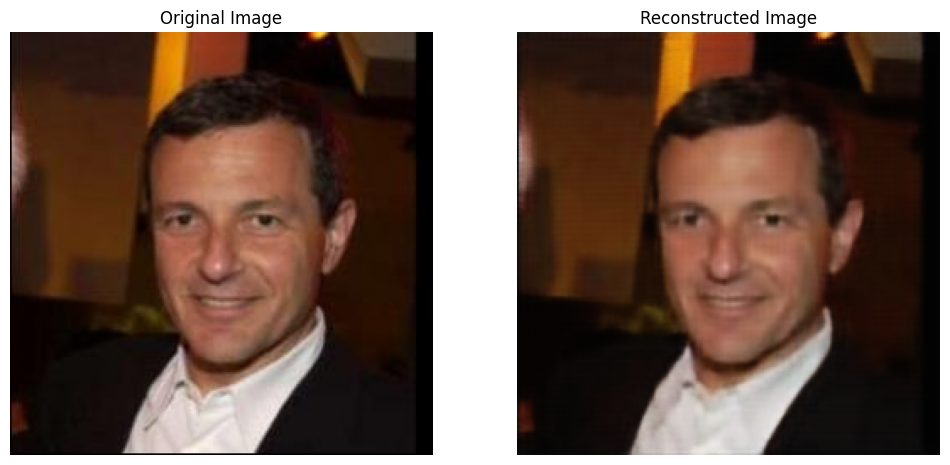

In [54]:
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import numpy as np
import torch

# Assuming 'dataloader' is your DataLoader instance
dataiter = iter(dataloader)
images, labels = next(dataiter)

# Select a random image from the batch
random_index = torch.randint(len(images), size=(1,)).item()
original_image = images[random_index]

# Add a batch dimension and pass the image through the autoencoder
# Make sure the model is in evaluation mode and on the correct device
model_initial.eval()
if torch.cuda.is_available():
    model_initial = model_initial.cuda()
    input_image = original_image.unsqueeze(0).cuda()
else:
    input_image = original_image.unsqueeze(0)

with torch.no_grad():
    reconstructed_image = model_initial(input_image)

# Convert the images to numpy for plotting
# Squeeze removes the batch dimension and detach takes it out of the computation graph
original_image_np = original_image.squeeze().detach().cpu().numpy()
reconstructed_image_np = reconstructed_image.squeeze().detach().cpu().numpy()

# Transpose the images from (C, H, W) to (H, W, C) for plotting
original_image_np = np.transpose(original_image_np, (1, 2, 0))
reconstructed_image_np = np.transpose(reconstructed_image_np, (1, 2, 0))

# Plotting
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(original_image_np)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Reconstructed Image")
plt.imshow(reconstructed_image_np)
plt.axis('off')

plt.show()

##  Step 8

In step 7, add a small normaly distrubuted noise to the latent (hidden) representation of the input image and then decode it again. How is adding noise affecting the decoded image ?

The addition of normally distributed noise to the latent space has discernible effects on the decoded image. As demonstrated by the 'Reconstructed Noisy Image,' the noise introduces a level of distortion, visible as a degradation of clarity and detail compared to the 'Reconstructed Image' generated from the noise-free latent representation. This experiment highlights the autoencoder's sensitivity to variations in its encoded representation and can be used to gauge the robustness of the feature extraction and reconstruction process. In practical terms, the model's ability to partially recover the original image from the noisy latent representation suggests a certain degree of resilience and robustness in the face of input perturbations, which is desirable in real-world applications where data is often imperfect. However, the visible differences also underscore the importance of a clean and stable latent space for high-fidelity reconstruction.

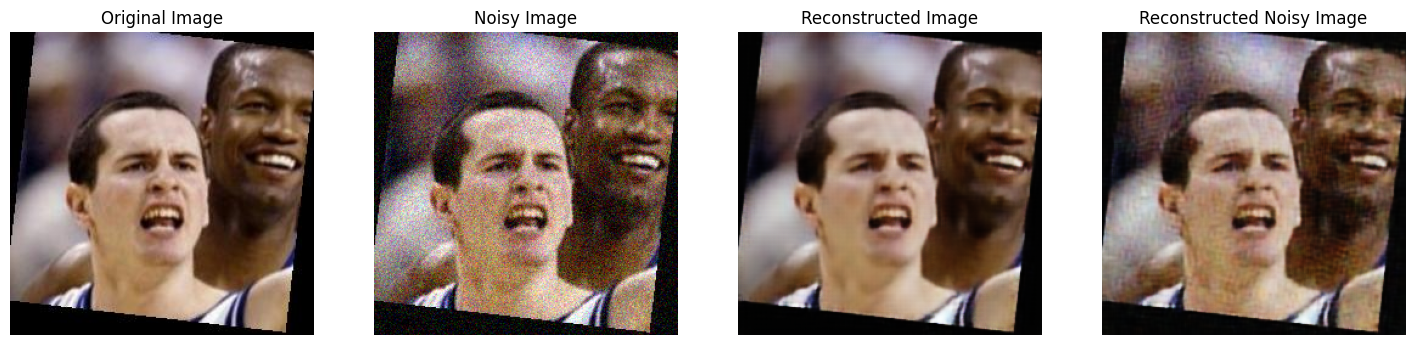

In [47]:
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import numpy as np
import torch

# Function to add Gaussian noise
def add_gaussian_noise(image, mean=0, std=0.1):
    noise = torch.randn(image.size()) * std + mean
    noisy_image = image + noise
    return torch.clamp(noisy_image, 0, 1)

# Load a batch of images from the dataloader
dataiter = iter(dataloader)
images, labels = next(dataiter)

# Select a random image from the batch
random_index = torch.randint(len(images), size=(1,)).item()
original_image = images[random_index]

# Add Gaussian noise to the image
noisy_image = add_gaussian_noise(original_image)

# Add a batch dimension and pass the original and noisy images through the autoencoder
model_initial.eval()
if torch.cuda.is_available():
    model_initial = model_initial.cuda()
    input_image = original_image.unsqueeze(0).cuda()
    input_noisy_image = noisy_image.unsqueeze(0).cuda()
else:
    input_image = original_image.unsqueeze(0)
    input_noisy_image = noisy_image.unsqueeze(0)

with torch.no_grad():
    reconstructed_image = model_initial(input_image)
    reconstructed_noisy_image = model_initial(input_noisy_image)

# Convert the images to numpy for plotting
original_image_np = original_image.squeeze().detach().cpu().numpy()
noisy_image_np = noisy_image.squeeze().detach().cpu().numpy()
reconstructed_image_np = reconstructed_image.squeeze().detach().cpu().numpy()
reconstructed_noisy_image_np = reconstructed_noisy_image.squeeze().detach().cpu().numpy()

# Transpose the images from (C, H, W) to (H, W, C) for plotting
original_image_np = np.transpose(original_image_np, (1, 2, 0))
noisy_image_np = np.transpose(noisy_image_np, (1, 2, 0))
reconstructed_image_np = np.transpose(reconstructed_image_np, (1, 2, 0))
reconstructed_noisy_image_np = np.transpose(reconstructed_noisy_image_np, (1, 2, 0))

# Plotting
plt.figure(figsize=(18, 6))
plt.subplot(1, 4, 1)
plt.title("Original Image")
plt.imshow(original_image_np)
plt.axis('off')

plt.subplot(1, 4, 2)
plt.title("Noisy Image")
plt.imshow(noisy_image_np)
plt.axis('off')

plt.subplot(1, 4, 3)
plt.title("Reconstructed Image")
plt.imshow(reconstructed_image_np)
plt.axis('off')

plt.subplot(1, 4, 4)
plt.title("Reconstructed Noisy Image")
plt.imshow(reconstructed_noisy_image_np)
plt.axis('off')

plt.show()


In [24]:
import torch.nn.functional as F

# Improved Autoencoder Architecture
class ImprovedAE(nn.Module):
    def __init__(self):
        super(ImprovedAE, self).__init__()

        # Encoder Layers
        self.enc_conv1 = nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1)
        self.enc_conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1)
        self.enc_conv3 = nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1)
        self.enc_conv4 = nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1)

        # Decoder Layers
        self.dec_conv1 = nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1)
        self.dec_conv2 = nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1)
        self.dec_conv3 = nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1)
        self.dec_conv4 = nn.ConvTranspose2d(32, 16, kernel_size=4, stride=2, padding=1)
        # Adjusted final layer to achieve 250x250 output
        self.dec_conv5 = nn.ConvTranspose2d(16, 3, kernel_size=4, stride=1, padding=0)

    def encoder(self, x):
        x = F.relu(self.enc_conv1(x))
        x = F.relu(self.enc_conv2(x))
        x = F.relu(self.enc_conv3(x))
        x = F.relu(self.enc_conv4(x))
        return x

    def decoder(self, x):
        x = F.relu(self.dec_conv1(x))
        x = F.relu(self.dec_conv2(x))
        x = F.relu(self.dec_conv3(x))
        x = torch.sigmoid(self.dec_conv4(x))  # Normalize the output
        x = self.dec_conv5(x)
        # Adjust the size using interpolation
        x = F.interpolate(x, size=(250, 250), mode='bilinear', align_corners=False)
        return x

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Initialize model, optimizer, and loss function
model_improved_arch = ImprovedAE()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_improved_arch.to(device)

# Optimizer and Loss Function
optimizer = torch.optim.Adam(model_improved_arch.parameters(), lr=0.001)  # Adjust learning rate
loss_function = nn.MSELoss()  # Mean Squared Error Loss

# Training Loop
num_epochs = 50  # You can adjust this as needed
for epoch in range(num_epochs):
    running_loss = 0.0
    for data in dataloader:
        inputs, _ = data
        inputs = inputs.to(device)

        optimizer.zero_grad()

        outputs = model_improved_arch(inputs)
        loss = loss_function(outputs, inputs)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    epoch_loss = running_loss / len(dataloader)
    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss}')

Epoch 1/50, Loss: 0.027395987808974325
Epoch 2/50, Loss: 0.005760456498370366
Epoch 3/50, Loss: 0.004338026813294396
Epoch 4/50, Loss: 0.003652306415302598
Epoch 5/50, Loss: 0.0032936524501934214
Epoch 6/50, Loss: 0.0030376660330491004
Epoch 7/50, Loss: 0.002846802586514125
Epoch 8/50, Loss: 0.0027042570825360247
Epoch 9/50, Loss: 0.0026082645950991894
Epoch 10/50, Loss: 0.0024307883279353092
Epoch 11/50, Loss: 0.0023790567900742526
Epoch 12/50, Loss: 0.002268808350869081
Epoch 13/50, Loss: 0.002198449100912121
Epoch 14/50, Loss: 0.002137317399804791
Epoch 15/50, Loss: 0.0020708973648292037
Epoch 16/50, Loss: 0.0020477771598751237
Epoch 17/50, Loss: 0.0019417942908214595
Epoch 18/50, Loss: 0.0019033648704115643
Epoch 19/50, Loss: 0.0018715139687655196
Epoch 20/50, Loss: 0.0018193688218882263
Epoch 21/50, Loss: 0.0017984794750292269
Epoch 22/50, Loss: 0.0017300152598322337
Epoch 23/50, Loss: 0.0016969702606413352
Epoch 24/50, Loss: 0.0016693594825571035
Epoch 25/50, Loss: 0.001649613227

### Model Architecture observation -
This model, on the other hand, shows a significant decrease in loss value from the first to the last epoch, indicating a steady learning process. It does not use average pooling and upsampling like the previous architecture but instead employs a series of convolutional and transposed convolutional layers, making it deeper with a potential for learning more complex hierarchical features. The inclusion of an additional layer and the removal of the average pooling layer could allow the model to retain more spatial information throughout the encoding and decoding processes, which is usually beneficial for the reconstruction quality in autoencoders.

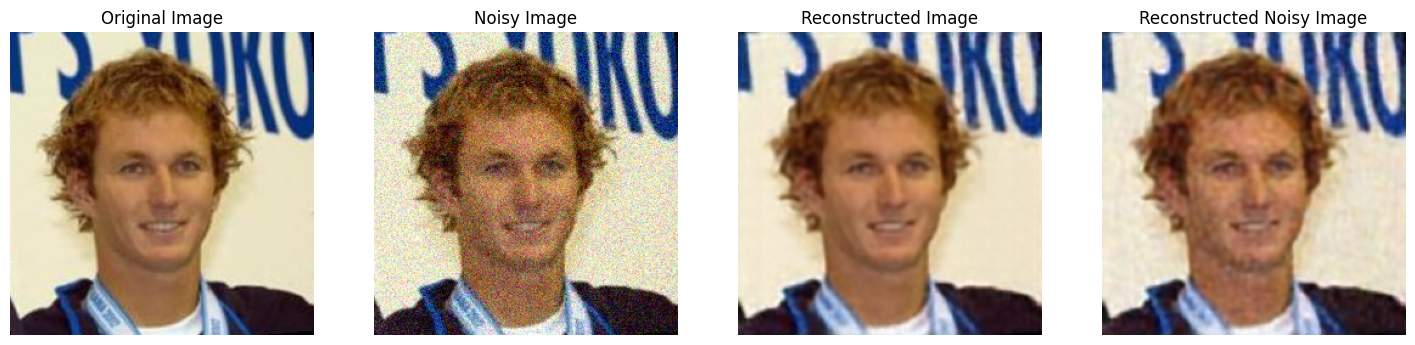

In [29]:
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import numpy as np
import torch

# Function to add Gaussian noise
def add_gaussian_noise(image, mean=0, std=0.1):
    noise = torch.randn(image.size()) * std + mean
    noisy_image = image + noise
    return torch.clamp(noisy_image, 0, 1)

# Load a batch of images from the dataloader
dataiter = iter(dataloader)
images, labels = next(dataiter)

# Select a random image from the batch
random_index = torch.randint(len(images), size=(1,)).item()
original_image = images[random_index]

# Add Gaussian noise to the image
noisy_image = add_gaussian_noise(original_image)

# Add a batch dimension and pass the original and noisy images through the autoencoder
model_improved_arch.eval()
if torch.cuda.is_available():
    model_improved_arch = model_improved_arch.cuda()
    input_image = original_image.unsqueeze(0).cuda()
    input_noisy_image = noisy_image.unsqueeze(0).cuda()
else:
    input_image = original_image.unsqueeze(0)
    input_noisy_image = noisy_image.unsqueeze(0)

with torch.no_grad():
    reconstructed_image = model_improved_arch(input_image)
    reconstructed_noisy_image = model_improved_arch(input_noisy_image)

# Convert the images to numpy for plotting
original_image_np = original_image.squeeze().detach().cpu().numpy()
noisy_image_np = noisy_image.squeeze().detach().cpu().numpy()
reconstructed_image_np = reconstructed_image.squeeze().detach().cpu().numpy()
reconstructed_noisy_image_np = reconstructed_noisy_image.squeeze().detach().cpu().numpy()

# Transpose the images from (C, H, W) to (H, W, C) for plotting
original_image_np = np.transpose(original_image_np, (1, 2, 0))
noisy_image_np = np.transpose(noisy_image_np, (1, 2, 0))
reconstructed_image_np = np.transpose(reconstructed_image_np, (1, 2, 0))
reconstructed_noisy_image_np = np.transpose(reconstructed_noisy_image_np, (1, 2, 0))

# Plotting
plt.figure(figsize=(18, 6))
plt.subplot(1, 4, 1)
plt.title("Original Image")
plt.imshow(original_image_np)
plt.axis('off')

plt.subplot(1, 4, 2)
plt.title("Noisy Image")
plt.imshow(noisy_image_np)
plt.axis('off')

plt.subplot(1, 4, 3)
plt.title("Reconstructed Image")
plt.imshow(reconstructed_image_np)
plt.axis('off')

plt.subplot(1, 4, 4)
plt.title("Reconstructed Noisy Image")
plt.imshow(reconstructed_noisy_image_np)
plt.axis('off')

plt.show()


In [30]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ImprovedAE(nn.Module):
    def __init__(self):
        super(ImprovedAE, self).__init__()

        # Encoder Layers
        self.enc_conv1 = nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1)
        self.enc_bn1 = nn.BatchNorm2d(32)
        self.enc_conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1)
        self.enc_bn2 = nn.BatchNorm2d(64)
        self.enc_conv3 = nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1)
        self.enc_bn3 = nn.BatchNorm2d(128)

        # Decoder Layers
        self.dec_conv1 = nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1)
        self.dec_bn1 = nn.BatchNorm2d(64)
        self.dec_conv2 = nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1)
        self.dec_bn2 = nn.BatchNorm2d(32)
        self.dec_conv3 = nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1)
        self.dec_bn3 = nn.BatchNorm2d(3)

        # Final Convolutional Layer (adjusted to fit the input size)
        self.dec_final = nn.Conv2d(3, 3, kernel_size=3, stride=1, padding=0)

    def encoder(self, x):
        skip_connections = []

        x = F.relu(self.enc_bn1(self.enc_conv1(x)))
        skip_connections.append(x)
        x = F.relu(self.enc_bn2(self.enc_conv2(x)))
        skip_connections.append(x)
        x = F.relu(self.enc_bn3(self.enc_conv3(x)))
        return x, skip_connections

    def decoder(self, x, skip_connections):
        x = F.relu(self.dec_bn1(self.dec_conv1(x)))
        # Resize the skip connection tensor before adding
        skip1 = F.interpolate(skip_connections[1], size=x.shape[2:], mode='bilinear', align_corners=False)
        x = x + skip1  # Add resized skip connection
        x = F.relu(self.dec_bn2(self.dec_conv2(x)))

        # Resize the second skip connection tensor before adding
        skip0 = F.interpolate(skip_connections[0], size=x.shape[2:], mode='bilinear', align_corners=False)
        x = x + skip0  # Add resized skip connection
        x = torch.sigmoid(self.dec_bn3(self.dec_conv3(x)))
        x = self.dec_final(x)  # Final convolutional layer

        # Resize the output to the desired dimensions (125x125)
        x = F.interpolate(x, size=(250, 250), mode='bilinear', align_corners=False)
        return x

    def forward(self, x):
        x, skip_connections = self.encoder(x)
        x = self.decoder(x, skip_connections)
        return x

# Create the model instance and move it to the appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ImprovedAE().to(device)


In [31]:
!pip install pytorch-msssim

In [33]:
from pytorch_msssim import ssim

def custom_loss_function(output, target):
    mse_loss = nn.MSELoss()(output, target)
    ssim_loss = ssim(output, target, data_range=1, size_average=True)  # Adjusted SSIM usage
    loss = mse_loss + (1.0 - ssim_loss)
    return loss

In [34]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
num_epochs = 30  # Adjust as needed

for epoch in range(num_epochs):
    running_loss = 0.0
    for data in dataloader:  # Assuming dataloader is defined
        inputs, _ = data
        inputs = inputs.to(device)  # Send data to the appropriate device

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = custom_loss_function(outputs, inputs)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(dataloader)}')


Epoch 1/30, Loss: 0.2072863143639288
Epoch 2/30, Loss: 0.09551054379646329
Epoch 3/30, Loss: 0.08820002439661302
Epoch 4/30, Loss: 0.0832862221694367
Epoch 5/30, Loss: 0.0807687944782097
Epoch 6/30, Loss: 0.07918456287667659
Epoch 7/30, Loss: 0.07879459384630844
Epoch 8/30, Loss: 0.07450570769895966
Epoch 9/30, Loss: 0.07627753689345243
Epoch 10/30, Loss: 0.07398817635136815
Epoch 11/30, Loss: 0.07243246433059662
Epoch 12/30, Loss: 0.07249146171706022
Epoch 13/30, Loss: 0.06780166268024755
Epoch 14/30, Loss: 0.06641986208477459
Epoch 15/30, Loss: 0.06513931782205323
Epoch 16/30, Loss: 0.06445661561500624
Epoch 17/30, Loss: 0.05847979591628492
Epoch 18/30, Loss: 0.05443697353456044
Epoch 19/30, Loss: 0.047371928125691874
Epoch 20/30, Loss: 0.04548376400905531
Epoch 21/30, Loss: 0.044596489113957985
Epoch 22/30, Loss: 0.04337583787757274
Epoch 23/30, Loss: 0.04254457691531394
Epoch 24/30, Loss: 0.040861487933007125
Epoch 25/30, Loss: 0.0401466759191691
Epoch 26/30, Loss: 0.03990646481405

### Model architecture observation -
The above architecture introduces skip connections, which are known for helping with the gradient flow during backpropagation and allowing the model to learn more detailed reconstructions by directly passing information from the encoder to the decoder. The loss values for Model 3 show a substantial decrease and continue to improve over time, which suggests that skip connections are beneficial for the learning process.

The loss function used in Model 3 is a combination of MSE and Structural Similarity Index (SSIM). The MSE loss alone (used in Model 2) provides pixel-wise error measurement, while SSIM gives a perception-based model that considers changes in structural information, texture, contrast, and luminance. The combination can yield a more comprehensive measure of reconstruction quality, which is likely contributing to the improved loss values.

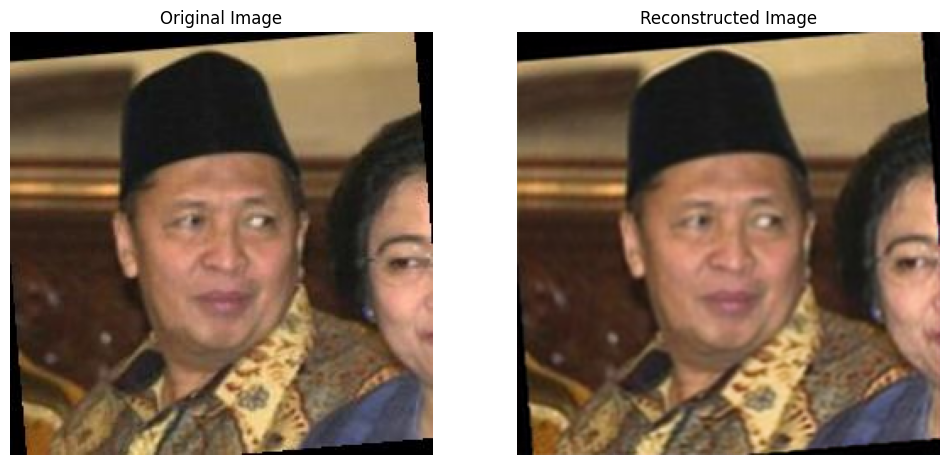

In [35]:
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import numpy as np
import torch

# Assuming 'dataloader' is your DataLoader instance
dataiter = iter(dataloader)
images, labels = next(dataiter)

# Select a random image from the batch
random_index = torch.randint(len(images), size=(1,)).item()
original_image = images[random_index]

# Add a batch dimension and pass the image through the autoencoder
# Make sure the model is in evaluation mode and on the correct device
model.eval()
if torch.cuda.is_available():
    model = model.cuda()
    input_image = original_image.unsqueeze(0).cuda()
else:
    input_image = original_image.unsqueeze(0)

with torch.no_grad():
    reconstructed_image = model(input_image)

# Convert the images to numpy for plotting
# Squeeze removes the batch dimension and detach takes it out of the computation graph
original_image_np = original_image.squeeze().detach().cpu().numpy()
reconstructed_image_np = reconstructed_image.squeeze().detach().cpu().numpy()

# Transpose the images from (C, H, W) to (H, W, C) for plotting
original_image_np = np.transpose(original_image_np, (1, 2, 0))
reconstructed_image_np = np.transpose(reconstructed_image_np, (1, 2, 0))

# Plotting
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(original_image_np)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Reconstructed Image")
plt.imshow(reconstructed_image_np)
plt.axis('off')

plt.show()


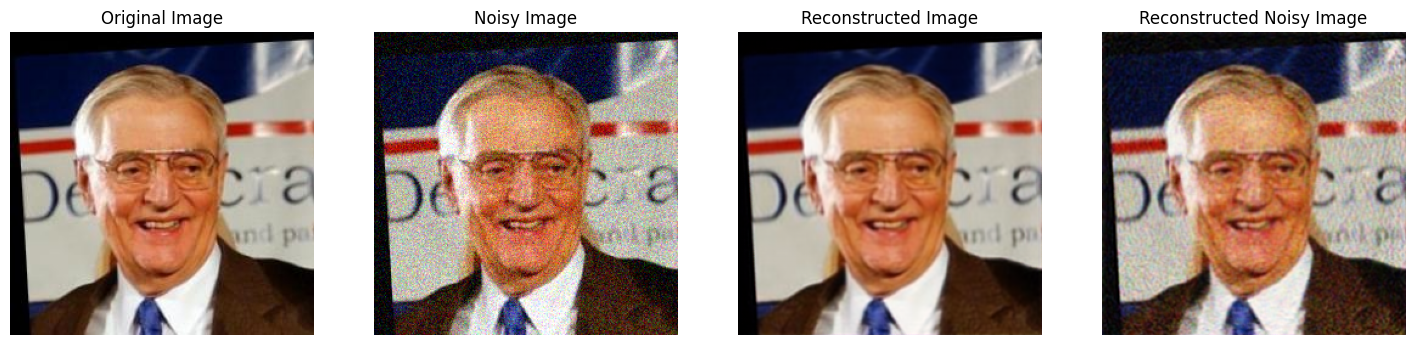

In [41]:
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import numpy as np
import torch

# Function to add Gaussian noise
def add_gaussian_noise(image, mean=0, std=0.1):
    noise = torch.randn(image.size()) * std + mean
    noisy_image = image + noise
    return torch.clamp(noisy_image, 0, 1)

# Load a batch of images from the dataloader
dataiter = iter(dataloader)
images, labels = next(dataiter)

# Select a random image from the batch
random_index = torch.randint(len(images), size=(1,)).item()
original_image = images[random_index]

# Add Gaussian noise to the image
noisy_image = add_gaussian_noise(original_image)

# Add a batch dimension and pass the original and noisy images through the autoencoder
model.eval()
if torch.cuda.is_available():
    model = model.cuda()
    input_image = original_image.unsqueeze(0).cuda()
    input_noisy_image = noisy_image.unsqueeze(0).cuda()
else:
    input_image = original_image.unsqueeze(0)
    input_noisy_image = noisy_image.unsqueeze(0)

with torch.no_grad():
    reconstructed_image = model(input_image)
    reconstructed_noisy_image = model(input_noisy_image)

# Convert the images to numpy for plotting
original_image_np = original_image.squeeze().detach().cpu().numpy()
noisy_image_np = noisy_image.squeeze().detach().cpu().numpy()
reconstructed_image_np = reconstructed_image.squeeze().detach().cpu().numpy()
reconstructed_noisy_image_np = reconstructed_noisy_image.squeeze().detach().cpu().numpy()

# Transpose the images from (C, H, W) to (H, W, C) for plotting
original_image_np = np.transpose(original_image_np, (1, 2, 0))
noisy_image_np = np.transpose(noisy_image_np, (1, 2, 0))
reconstructed_image_np = np.transpose(reconstructed_image_np, (1, 2, 0))
reconstructed_noisy_image_np = np.transpose(reconstructed_noisy_image_np, (1, 2, 0))

# Plotting
plt.figure(figsize=(18, 6))
plt.subplot(1, 4, 1)
plt.title("Original Image")
plt.imshow(original_image_np)
plt.axis('off')

plt.subplot(1, 4, 2)
plt.title("Noisy Image")
plt.imshow(noisy_image_np)
plt.axis('off')

plt.subplot(1, 4, 3)
plt.title("Reconstructed Image")
plt.imshow(reconstructed_image_np)
plt.axis('off')

plt.subplot(1, 4, 4)
plt.title("Reconstructed Noisy Image")
plt.imshow(reconstructed_noisy_image_np)
plt.axis('off')

plt.show()


In [38]:
def add_noise(imgs):
    # Adding random Gaussian noise
    noise_factor = 0.5
    noisy_imgs = imgs + noise_factor * torch.randn_like(imgs)
    noisy_imgs = torch.clip(noisy_imgs, 0., 1.)
    return noisy_imgs

In [39]:
class DenoisingAE(nn.Module):
    def __init__(self):
        super(DenoisingAE, self).__init__()

        # Encoder Layers
        self.enc1 = nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1)
        self.enc2 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)
        self.enc3 = nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1)

        # Decoder Layers
        self.dec1 = nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.dec2 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1)
        #self.dec3 = nn.ConvTranspose2d(64, 3, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.dec3 = nn.ConvTranspose2d(64, 16, kernel_size=3, stride=2, padding=1)
        self.dec4 = nn.ConvTranspose2d(16, 3, kernel_size=4, stride=1, padding=0)


    def encoder(self, x):
        x = F.relu(self.enc1(x))
        x = F.relu(self.enc2(x))
        x = F.relu(self.enc3(x))
        return x

    def decoder(self, x):
        x = F.relu(self.dec1(x))
        x = F.relu(self.dec2(x))
        x = torch.sigmoid(self.dec3(x))
        #x = torch.sigmoid(self.dec_conv4(x))  # Normalize the output
        x = self.dec4(x)
        # Adjust the size using interpolation
        x = F.interpolate(x, size=(250, 250), mode='bilinear', align_corners=False)
        return x

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


In [39]:
# Assume dataloader, loss_function, optimizer are defined

model_denoising = DenoisingAE().to(device)
num_epochs = 30

for epoch in range(num_epochs):
    running_loss = 0.0
    for data in dataloader:
        inputs, _ = data
        noisy_inputs = add_noise(inputs).to(device)
        clean_inputs = inputs.to(device)

        optimizer.zero_grad()

        outputs = model_denoising(noisy_inputs)
        loss = loss_function(outputs, clean_inputs)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(dataloader)}')


Epoch 1/10, Loss: 0.13374699317458746
Epoch 2/10, Loss: 0.13374131586816576
Epoch 3/10, Loss: 0.13372671188435692


KeyboardInterrupt: ignored

### My observations
The loss values suggest that the deeper, more complex models with additional features such as skip connections introducted in (Model #3) and without average pooling layers (Model #2) are more capable of capturing and reconstructing the input data. Model #3, with its combination of MSE and SSIM for the loss function, shows the best performance in terms of steadily decreasing loss, indicating a balance between pixel fidelity and perceptual quality in reconstruction. This suggests that the choice of a more complex architecture, coupled with a hybrid loss function, is better for the given task. Given the computational limitations of my device, I couldn't build and train complex models on the lfw dataset. Additionally, I wanted to implement a denoising Autoencoder by perform preprocessing steps like normalization and noise reduction on the images (Something I can work on in the next assignment).

### References
1. LLM models like GPT
2. Kaggle notebooks
2. Blogs on Analytics Vidhya